### Econometrics2
### Differences-in-Differences (DiD) estimation; Causal inference and identification assumptions; Data cleaning and transformation; Empirical analysis of digital infrastructure and labor market outcomes
### Mingshu Li

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import numpy as np
import statsmodels.formula.api as smf

In [3]:
full_ps3data = pd.read_csv('ps3data.csv')

### Problem 1.1

In [8]:
ps3 = full_ps3data[full_ps3data['wave'].isin(['Wave 4', 'Wave 5'])]

selected_columns = ['employment_status', 'wave','distance', 'country_name', 'year_wave', 'educ_level']
ps3 = ps3[selected_columns]
ps3.replace([8, 9, -1], np.nan, inplace=True) #eliminate all the missing data
ps3 = ps3.dropna()

connection_year = {
    'Benin': 2010,
    'D.R. Congo': 2012,
    'Ghana': 2010,
    'Kenya': 2009,
    'Madagascar': 2010,
    'Mozambique': 2009,
    'Namibia': 2012,
    'Nigeria': 2010,
    'Senegal': 2010,
    'South Africa': 2009,
    'Tanzania': 2009,
    'Togo': 2010
}
ps3['submarine']  = ps3.apply(lambda x: 1 if x['year_wave'] >= connection_year.get(x['country_name'], float('inf')) else 0, axis=1)

ps3['connected']  = ps3['distance'].apply(lambda x: 1 if x < 0.1 else 0)

ps3['treatment']  = ps3['submarine'] * ps3['connected']

#Adjust the employment data for further analyze, since wave4 and wave5 have two different standard. 
#After adjust, 1 represents Not employed, 2 represents part-time, and 3 represents full-time
def categorize_employment(row):
    if row['wave'] == 'Wave 4':
        if row['employment_status'] in [0, 1]:
            return 1 
        elif row['employment_status'] in [2, 3]:
            return 2 
        elif row['employment_status'] in [4, 5]:
            return 3 
    elif row['wave'] == 'Wave 5':
        if row['employment_status'] in [0, 1]:
            return 1 
        elif row['employment_status'] == 2:
            return 2 
        elif row['employment_status'] == 3:
            return 3 
    return None 
ps3['employment_new'] = ps3.apply(categorize_employment, axis=1) # we are using this employment for further analyze

ps3 #checking the data

,employment_status,wave,distance,country_name,year_wave,educ_level,submarine,connected,treatment,employment_new
0,0.0,Wave 4,0.225779,Benin,2008.0,4.0,0,0,0,1
1,1.0,Wave 4,0.225779,Benin,2008.0,2.0,0,0,0,1
2,2.0,Wave 4,0.225779,Benin,2008.0,4.0,0,0,0,2
3,1.0,Wave 4,0.225779,Benin,2008.0,3.0,0,0,0,1
4,1.0,Wave 4,0.225779,Benin,2008.0,4.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
79295,3.0,Wave 5,0.002493,Zimbabwe,2012.0,7.0,0,1,0,3
79296,3.0,Wave 5,0.002493,Zimbabwe,2012.0,6.0,0,1,0,3
79297,2.0,Wave 5,0.002493,Zimbabwe,2012.0,5.0,0,1,0,2
79298,2.0,Wave 5,0.002493,Zimbabwe,2012.0,5.0,0,1,0,2


### Problem 1.2

In [11]:
descrip_stat = ps3.groupby('connected')[['treatment', 'submarine', 'employment_status']].agg(['count', 'mean', 'std'])
descrip_stat

treatment                     submarine                      \
              count      mean       std     count      mean       std   
connected                                                               
0             27260  0.000000  0.000000     27260  0.254145  0.435388   
1             36446  0.352988  0.477906     36446  0.352988  0.477906   

          employment_status                      
                      count      mean       std  
connected                                        
0                     27260  1.145121  1.285473  
1                     36446  1.400181  1.395192

### Problem 1.3

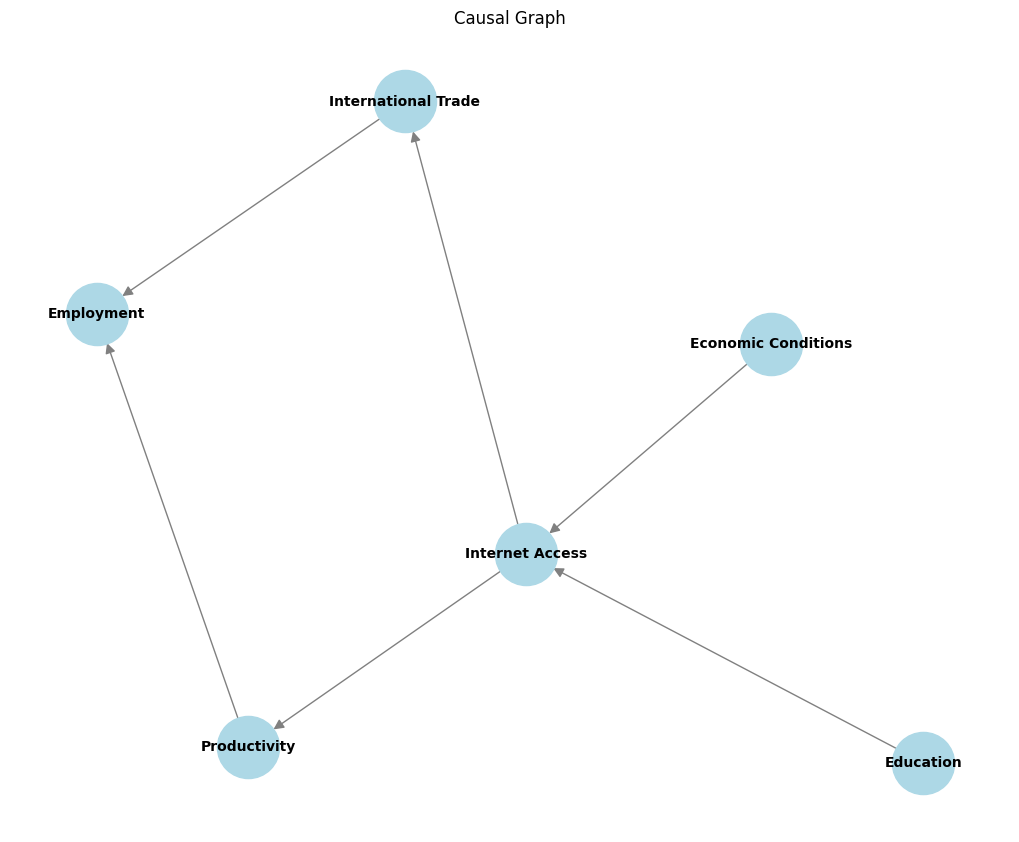

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node('Economic Conditions')
G.add_node('Education')
G.add_node('Internet Access')
G.add_node('Productivity')
G.add_node('Employment')
G.add_node('International Trade')
edges = [
    ('Economic Conditions', 'Internet Access'),
    ('Education', 'Internet Access'),
    ('Internet Access', 'Productivity'),
    ('Internet Access', 'International Trade'),
    ('Productivity', 'Employment'),
    ('International Trade', 'Employment')
]
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=7) 
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos, with_labels=True, arrows=True, edgelist=edges, style='solid',
    node_size=2000, font_size=10, font_weight='bold', node_color="lightblue",
    edge_color="gray", arrowstyle="-|>", arrowsize=15
)
plt.title("Causal Graph")
plt.show()

### Problem 1.4

DiD model:
Employmentist = α + 𝛄Connecteds + λSubmarinet + 𝛿Treatmentst + εist

In this problem, our treatment ‘Connected’ is the interviewee live far(0) or close(1) to terrestrial fiber cables; time ‘Submarine’ pre(0) and post(1) connected to the Internet; then the treatment group will be when both applied(1). In order to find an unbiased treatment effect, we want to make sure the parallel assumption holds. 

### Problem 1.5

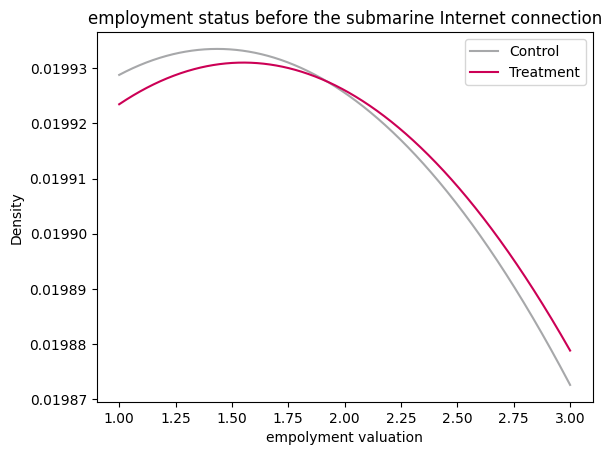

In [19]:
pre_internet = ps3[ps3['submarine'] == 0]

control_data = pre_internet[pre_internet['connected'] == 0]['employment_new']
treatment_data = pre_internet[pre_internet['connected'] == 1]['employment_new']


# Create a density plot for the control group
kde_control = KernelDensity(bandwidth=20, kernel='gaussian')
kde_control.fit(control_data.values.reshape(-1, 1))
x_control = np.linspace(min(control_data), max(control_data), 1000)
density_control = np.exp(kde_control.score_samples(x_control.reshape(-1, 1)))
plt.plot(x_control, density_control, color='#a7a8aa', label='Control')

# Create a density plot for the treatment group
kde_treatment = KernelDensity(bandwidth=20, kernel='gaussian')
kde_treatment.fit(treatment_data.values.reshape(-1, 1))
x_treatment = np.linspace(min(treatment_data), max(treatment_data), 1000)
density_treatment = np.exp(kde_treatment.score_samples(x_treatment.reshape(-1, 1)))
plt.plot(x_treatment, density_treatment, color='#cc0055', label='Treatment')


# Set plot labels and title
plt.title('employment status before the submarine Internet connection')
plt.xlabel('empolyment valuation')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The parallel trends assumption is satisfied but not in a perfect or strong parallel relationship as two lines are slightly different. By looking through the graph of pre_submarine, we can see the line for control group and treatment group that follow the same trend but Treatment group is slightly higher than the control group. Also, by comparing the pre and post graphs, we can see there is no significant effect of treatment(did), as we can hardly see the difference or changes. 

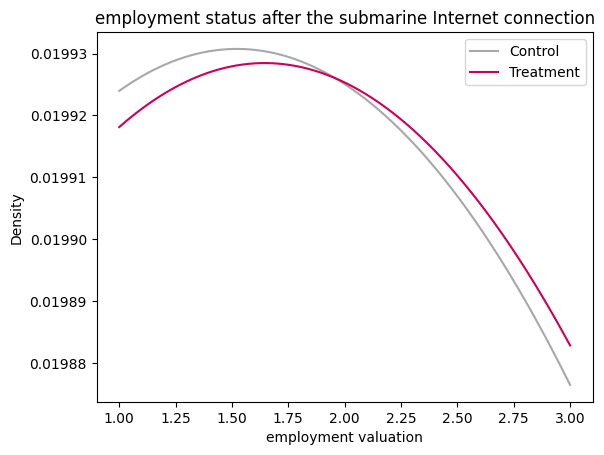

In [22]:
post_internet = ps3[ps3['submarine'] == 1]

control_data = post_internet[post_internet['connected'] == 0]['employment_new']
treatment_data = post_internet[post_internet['connected'] == 1]['employment_new']


# Create a density plot for the control group
kde_control = KernelDensity(bandwidth=20, kernel='gaussian')
kde_control.fit(control_data.values.reshape(-1, 1))
x_control = np.linspace(min(control_data), max(control_data), 1000)
density_control = np.exp(kde_control.score_samples(x_control.reshape(-1, 1)))
plt.plot(x_control, density_control, color='#a7a8aa', label='Control')

# Create a density plot for the treatment group
kde_treatment = KernelDensity(bandwidth=20, kernel='gaussian')
kde_treatment.fit(treatment_data.values.reshape(-1, 1))
x_treatment = np.linspace(min(treatment_data), max(treatment_data), 1000)
density_treatment = np.exp(kde_treatment.score_samples(x_treatment.reshape(-1, 1)))
plt.plot(x_treatment, density_treatment, color='#cc0055', label='Treatment')


# Set plot labels and title
plt.title('employment status after the submarine Internet connection')
plt.xlabel('employment valuation')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Problem 1.6

In [25]:
model1 = smf.ols('employment_new ~ C(connected) + C(submarine) + C(treatment)', data=ps3).fit(cov_type = 'HC3')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         employment_new   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     190.7
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          3.78e-123
Time:                        18:00:17   Log-Likelihood:                -76014.
No. Observations:               63706   AIC:                         1.520e+05
Df Residuals:                   63702   BIC:                         1.521e+05
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4355      0.005    276.663      0.000       1.425       1.446
C(connected)[T.1]     0.1160      0.007     15.739      0.000       0.102       0.130
C(submarine)[T.1]     0.0873      0.011      7.909      0.000       0.066       0.109
C(treatment)[T.1]     0.0068      0.014      0.472      0.637      -0.021       0.035
==============================================================================
Omnibus:                    10261.251   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12298.803
Skew:                           1.029   Prob(JB):                         0.00
Kurtosis:                       2.370   Cond. No.                         7.10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Interpretation for our result:
Treatment (0.0068, p = 0.637): The coefficient for treatment is not significant, suggesting that the treatment does not have a substantial effect on employment status. Also, the coefficient for treatment in our regression is negative, suggesting that the treatment have a negative impact on employment status.

Explanation for our choices:
Submarine Variable: Represents the time when the internet expansion was introduced, showing pre- and post-treatment comparison.
Connected Variable: Indicates whether areas are connected to the internet, which could impact employment independently of submarine cable access.

Treatment Variable (=Submarine:Connected (the DID interaction)): The term treatment captures the differential impact of the internet expansion on employment for the treatment group compared to the control group.

### Problem 1.7

In [29]:
model4 = smf.ols('employment_new ~ C(connected) + C(submarine) + C(treatment)', data=ps3).fit(cov_type = 'cluster', cov_kwds={'groups': ps3['educ_level']})
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         employment_new   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     8.755
Date:                Sun, 09 Mar 2025   Prob (F-statistic):            0.00659
Time:                        18:01:03   Log-Likelihood:                -76014.
No. Observations:               63706   AIC:                         1.520e+05
Df Residuals:                   63702   BIC:                         1.521e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4355      0.071     20.101      0.000       1.296       1.575
C(connected)[T.1]     0.1160      0.023      5.070      0.000       0.071       0.161
C(submarine)[T.1]     0.0873      0.029      3.039      0.002       0.031       0.144
C(treatment)[T.1]     0.0068      0.011      0.627      0.531      -0.014       0.028
==============================================================================
Omnibus:                    10261.251   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12298.803
Skew:                           1.029   Prob(JB):                         0.00
Kurtosis:                       2.370   Cond. No.                         7.10
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

The regression result in problem 1.6 shows that the effects of Internet expansion on employment is heterogeneous. We add a cluster based on the group ‘education level’ in this question, and the regression result of our model shows that the effects of Internet expansion on employment is still insignificant but the p-value of our treatment variable is slightly smaller than before. 


### Problem 1.8

The first thing is the limitation of the data. Since the place where researchers collected was lacking systematic and detailed labor market data, the research results might be biased. One example is the person who is likely to be recorded or filling out the survey is the person who had jobs and has more access to the internet compared to the people that are not even included in the dataset. 

The second problem is the geographic and economic differences. The unique geographic condition in Africa might make generalizing results difficult. And due to the different management structures in different areas, the levels of baseline economic development might be different. 

The third problem is the cultural factor. Due to the influence of different cultures and religious beliefs. Some women may not be allowed to work or get educated. This may cause bias.